# Problem 4

In [2]:
from collections import deque
import numpy as np
from tqdm import tqdm

import networkx as nx
from matplotlib import pyplot as plt

## Design of a streaming and sampling algorithm for dynamic networks 

A clever data structure in evaluating the number of connected components is the union-set one, also known as disjoint forest. This data structure supports three operations: 
+ ```make_set(x)```
+ ```find(x)```
+ ```union(x,y)```

To check if a graph is connected we just need to compute the number of distinct parents in the disjoint forest, that is exactly the number of connected components: if it is equal to 1, the graph is connected. This require us to compute an array with the parents of all nodes and then extract the unique values of this array. Unfortunately, this procedure is good for general dynamic scenarios, but not for our scenario, where there is forward and also backward deletion accordingly to the size of the window: the disjoint forest doesn't support the deletion of connection, since it "loses" information while it is populated. A very first brutal approach would be keep a double queue of fixed size (circular buffer) of the coming edges, and at each timestamp:
+ Initialize a disjoint forest;
+ Populate it;
+ Evaluate the number of connected components. 

In [2]:
class DisjointForest():
    def __init__(self):
        
        self.parents = {}
        self.rank = {}

    def find(self,
             node):
        
        try:
            if self.parents[node] != node:
                self.parents[node] = self.find(self.parents[node])

            return self.parents[node]
        
        except KeyError:
            return None
    
    def insert(self,
               node):
        
        if not self.find(node):
            self.parents[node] = node
            self.rank[node] = 0

    def union(self, 
              u, 
              v):
        
        self.insert(u)
        self.insert(v)
        
        root_u = self.find(u)
        root_v = self.find(v)

        if root_u != root_v:

            if self.rank[root_u] >= self.rank[root_v]:
                self.parents[root_v] = root_u
                self.rank[root_u] += 1
                
            elif self.rank[root_u] < self.rank[root_v]:
                self.parents[root_u] = root_v
                self.rank[root_v] += 1

    def connectivity(self):
        return 'Connected' if len(set([self.find(x) for x in self.parents.keys()])) == 1 else 'Disconnected'


In [3]:
def StreamingBrutal(edge_buffer, node_buffer): 
    DF = DisjointForest()
    for v in node_buffer:
        DF.insert(v)
    for edge in edge_buffer:
        DF.union(edge[0],edge[1])
    return DF.connectivity()

def edgeGenerator(V = 150):
    return tuple(np.random.choice(np.arange(V), size=(1,2), replace=False)[0])

def test(V, w, T):
    edge_buffer = deque(maxlen=w)
    node_buffer = set()
    
    num_cols = int(np.sqrt(T))
    num_rows = int(np.ceil(T / num_cols))
    
    _, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    
    axes = axes.flatten()  
    
    for i in tqdm(range(T)):
        e = edgeGenerator(V)
        node_buffer.add(e[0])
        node_buffer.add(e[1])
        edge_buffer.appendleft(e)

        G = nx.Graph()
        G.add_nodes_from(node_buffer)
        G.add_edges_from(edge_buffer)
        pos = nx.spring_layout(G, seed=4200)
        
        ax = axes[i]
        ax.set_title(str(StreamingBrutal(edge_buffer, node_buffer)))
        nx.draw(G, pos=pos, with_labels=True, ax=ax, node_size = 30, node_color = 'lightblue')

    for i in range(T, num_rows * num_cols):
        axes[i].axis('off')
    
    plt.show()

In [4]:
def test(V, w, T):
    edge_buffer = deque(maxlen=w)
    node_buffer = set()
    
    num_cols = int(np.sqrt(T))
    num_rows = int(np.ceil(T / num_cols))
    
    _, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    plt.subplots_adjust(hspace=0.5)
    
    axes = axes.flatten()  
    
    for i in tqdm(range(T)):
        e = edgeGenerator(V)
        node_buffer.add(e[0])
        node_buffer.add(e[1])
        edge_buffer.appendleft(e)

        G = nx.Graph()
        G.add_nodes_from(node_buffer)
        G.add_edges_from(edge_buffer)
        pos = nx.spring_layout(G, seed=4200)
        
        ax = axes[i]
        ax.set_title(str(StreamingBrutal(edge_buffer, node_buffer)))
        nx.draw(G, pos=pos, with_labels=True, ax=ax, node_size = 30, node_color = 'lightblue')

    for i in range(T, num_rows * num_cols):
        axes[i].axis('off')
    
    plt.show()

100%|██████████| 40/40 [00:00<00:00, 122.31it/s]


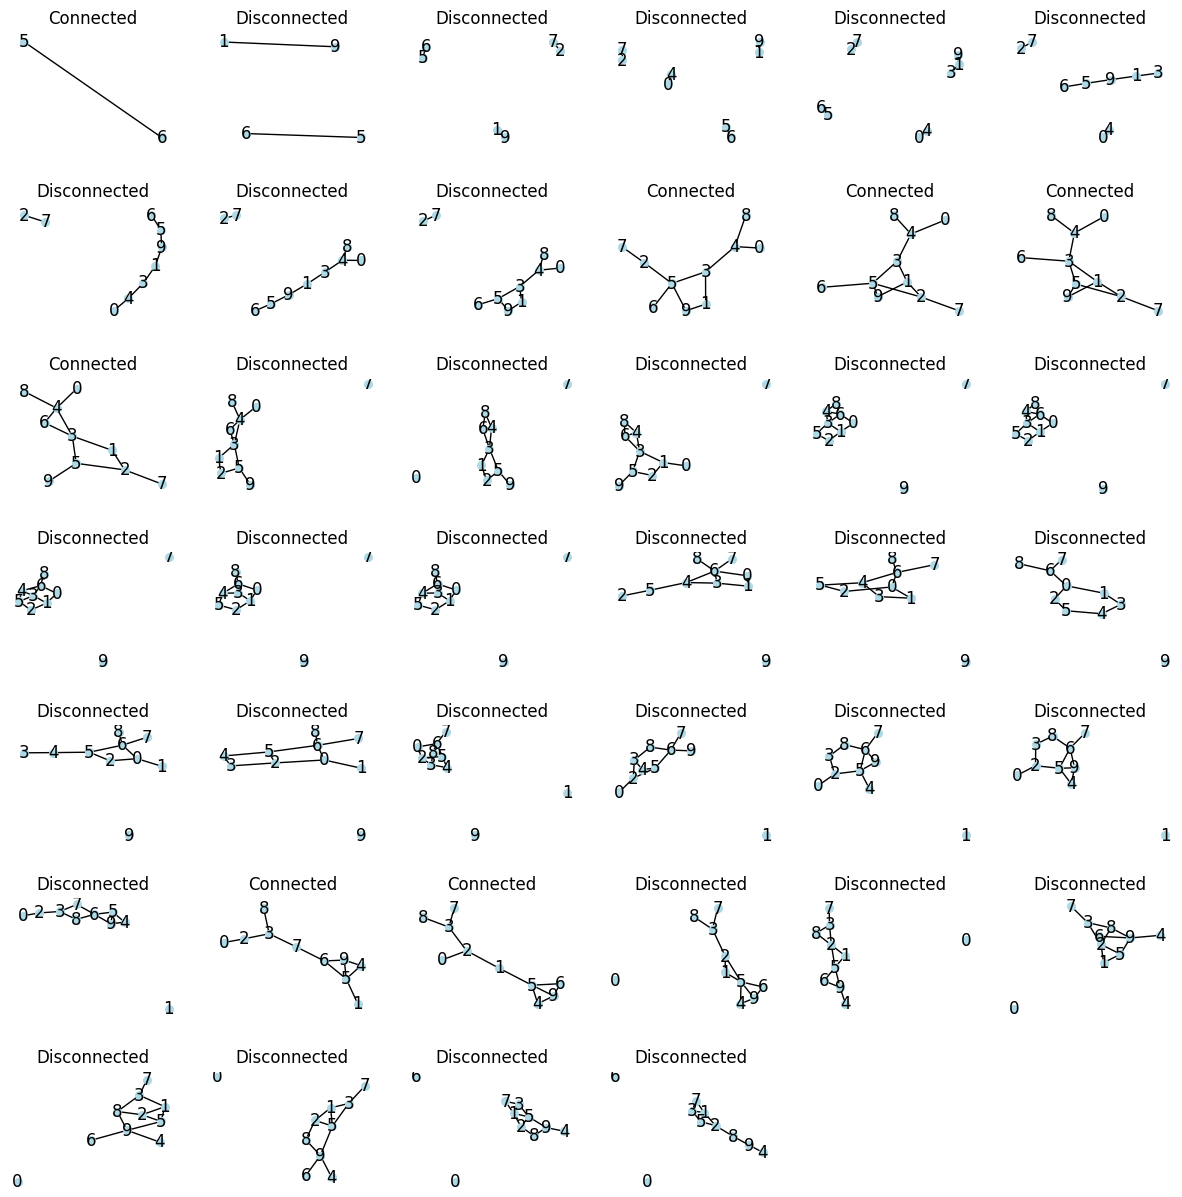

In [6]:
test(V = 10,
     w = 11,
     T = 40)

Unfortunately, this approach is not good from many perspectives of a streaming algorithm: 
+ It doesn't leverage the state in $t$ to compute the state in $t + 1$;
+ It requires $\mathcal{O}(V + E)$ memory for storing the buffer of the nodes and the buffer for the edges;
+ From a time complexity perspective, at each iteration we need to: 
    + Populate the disjoint forest with $V$ elements, but each operation is constant in time $\mathcal{O}(1)$;
    + Make $E$ ```union``` operation, whose complexity is $\mathcal{O}(E \log^* V)$;
    + Compute the number of connected components, whose amortized complexity is $\Theta(\alpha(V))$.

By the way we can make some improvements:

+ Once the first $w$ edges have come, when $(w + 1)$-th edge $e_{w+1} = (u,v)$ comes in order to decide connectivity we need to:
    + Check if ```find(u)``` and ```find(v)``` are both false: in that case the graph gets disconnected, we update the data structure and wait for the following edge to come;
+ Also the oldest edge $\widetilde{e} = (w,z)$ becomes inactive: if either ```rank(u) > 1``` or ```rank(v) > 1```, the graph becomes disconnected. 


____________________